In [56]:
# Import necessary libraries
import numpy as np  # For numerical operations
import os  # For interacting with the operating system
import cv2  # For image processing
from sklearn.model_selection import train_test_split  # For splitting the dataset into training and testing sets
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score  # For evaluating the model
from sklearn.metrics import ConfusionMatrixDisplay  # For displaying the confusion matrix
from sklearn.svm import SVC  # For Support Vector Machine classifier
from sklearn.neural_network import MLPClassifier  # For Neural Network classifier
from skimage.feature import hog  # For extracting Histogram of Oriented Gradients (HOG) features from images
from tabulate import tabulate  # For displaying the results in a tabular format
import tensorflow as tf  # For deep learning operations
from tensorflow.keras.models import Sequential  # For creating a linear stack of layers for the neural network
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization  # For defining different types of layers in the neural network
from tensorflow.keras.optimizers import Adam, SGD  # For optimizing the neural network

In [57]:
# Code to extract features from images, either HOG or raw pixels.

def extract_features(image_path, use_hog):
    """Load image and extract features (HOG or raw pixels)."""
    # Load the image in grayscale mode
    image = cv2.imdecode(np.fromfile(image_path, dtype=np.uint8), cv2.IMREAD_GRAYSCALE)
    
    # Check if the image was loaded successfully
    if image is None:
        raise ValueError(f"Image not found or unable to load: {image_path}")

    # Resize the image to a fixed size (128x128)
    image = cv2.resize(image, (128, 128))

    if use_hog:
        # Extract HOG features for ML classifiers
        features, _ = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
        return features  # Return 1D feature vector
    else:
        # Normalize pixel values for CNN (range 0-1)
        return image.reshape(128, 128, 1) / 255.0  # Return 2D image for CNN


Part A:
Binary Classification Using Handcrafted Features and ML Classifiers (4 Marks) 
- i. Extract handcrafted features from the dataset. 
- ii. Train and evaluate at least two machine learning classifiers (e.g., SVM, Neural 
network) to classify faces as "with mask" or "without mask." 
- iii. Report and compare the accuracy of the classifiers. 

In [58]:
# load the dataset for normal ML models require 1D feature vector (HOG)

# Set dataset path
dataset_path = "dataset"

# Storage for dataset
data = []
labels = []
label_counts = {'with_mask': 0, 'without_mask': 0}


# Load dataset
for label in ['with_mask', 'without_mask']:
    folder_path = os.path.join(dataset_path, label)
    # print(f"Processing folder: {folder_path}")
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        # print(f"Processing file: {file_path}")
        try:
            features = extract_features(file_path, use_hog=True)
            data.append(features)
            labels.append(1 if label == 'with_mask' else 0) # Encode 'with_mask' as 1 and 'without_mask' as 0
            label_counts[label] += 1
        except ValueError as e:
            print(e) # Print the error message
        except Exception as e:
            print(f"Unexpected error processing file {file_path}: {e}")


# Convert to numpy arrays
X = np.array(data)
y = np.array(labels)

# Print dataset shape
print(f"Feature array shape: {X.shape}, Labels shape: {y.shape}")
print(f"Number of 'with_mask' images: {label_counts['with_mask']}")
print(f"Number of 'without_mask' images: {label_counts['without_mask']}")

Feature array shape: (4095, 8100), Labels shape: (4095,)
Number of 'with_mask' images: 2165
Number of 'without_mask' images: 1930


In [59]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the sizes of the training and testing sets
print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

Training set size: 3276
Testing set size: 819


In [60]:
# Train and evaluate SVM classifier
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
y_pred_svm = svm_clf.predict(X_test)
svm_accuracy = accuracy_score(y_test, y_pred_svm)

# Report the accuracy of the SVM classifier
print(f"SVM Accuracy: {svm_accuracy}")

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_svm))

SVM Accuracy: 0.9304029304029304
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92       366
           1       0.91      0.96      0.94       453

    accuracy                           0.93       819
   macro avg       0.93      0.93      0.93       819
weighted avg       0.93      0.93      0.93       819



Confusion Matrix:


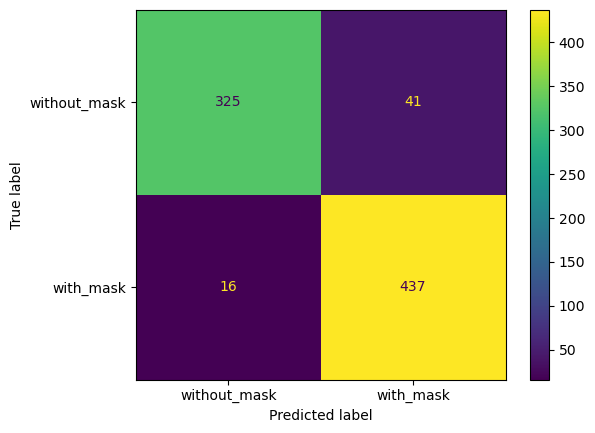

In [61]:

# Print confusion matrix
print("Confusion Matrix:")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm, display_labels=['without_mask', 'with_mask'])

In [62]:
# Train and evaluate Neural Network classifier
nn_clf = MLPClassifier()
nn_clf.fit(X_train, y_train)
y_pred_nn = nn_clf.predict(X_test)
nn_accuracy = accuracy_score(y_test, y_pred_nn)

# Report the accuracy of the MLP classifier
print(f"Neural Network Accuracy: {nn_accuracy}")

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_nn))

Neural Network Accuracy: 0.9035409035409036
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89       366
           1       0.90      0.93      0.91       453

    accuracy                           0.90       819
   macro avg       0.90      0.90      0.90       819
weighted avg       0.90      0.90      0.90       819



Confusion Matrix:


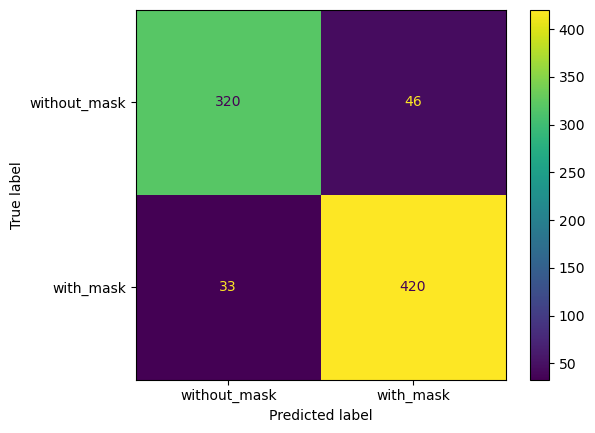

In [63]:
# Print confusion matrix
print("Confusion Matrix:")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_nn, display_labels=['without_mask', 'with_mask'])

Part B. Binary Classification Using CNN (3 Marks) 
- i.Design and train a Convolutional Neural Network (CNN) to perform binary 
classification on the same dataset. 
- ii.Try a few hyper-parameter variations (e.g., learning rate, batch size, optimizer, activation function in the classification layer) and report the results. 
- iii.Compare the CNN's performance with the ML classifiers. 

In [64]:
# Load the dataset for CNN model require 2D image array
# Set dataset path
dataset_path = "dataset"

# Storage for dataset
data = []
labels = []
label_counts = {'with_mask': 0, 'without_mask': 0}


# Load dataset
for label in ['with_mask', 'without_mask']:
    folder_path = os.path.join(dataset_path, label)
    # print(f"Processing folder: {folder_path}")
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        # print(f"Processing file: {file_path}")
        try:
            features = extract_features(file_path, use_hog=False)
            data.append(features)
            labels.append(1 if label == 'with_mask' else 0)
            label_counts[label] += 1
        except ValueError as e:
            print(e) # Print the error message
        except Exception as e:
            print(f"Unexpected error processing file {file_path}: {e}")


# Convert to numpy arrays
X = np.array(data)
y = np.array(labels)

# Print dataset shape
print(f"Feature array shape: {X.shape}, Labels shape: {y.shape}")
print(f"Number of 'with_mask' images: {label_counts['with_mask']}")
print(f"Number of 'without_mask' images: {label_counts['without_mask']}")



Feature array shape: (4095, 128, 128, 1), Labels shape: (4095,)
Number of 'with_mask' images: 2165
Number of 'without_mask' images: 1930


In [65]:
# One-hot encode labels for categorical cross-entropy loss
y = tf.keras.utils.to_categorical(y, 2)

# Split dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print shapes to verify
print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Testing set shape: {X_test.shape}, {y_test.shape}")


Training set shape: (3276, 128, 128, 1), (3276, 2)
Testing set shape: (819, 128, 128, 1), (819, 2)


In [66]:
# -------------------------- CNN Model 1 --------------------------
def cnn_model_1():
    """CNN Model 1: Uses Adam optimizer, and higher dropout."""
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),  # Prevent overfitting
        Dense(2, activation='sigmoid')  # as 2 output classes
    ])

    # Compile model using Adam optimizer
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=0.001),
                  metrics=['accuracy'])
    
    return model

# Train CNN Model 1
cnn_model_1 = cnn_model_1()
print("\nTraining CNN Model 1 (Adam, higher dropout)...")
history_1 = cnn_model_1.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))
test_loss_1, test_acc_1 = cnn_model_1.evaluate(X_test, y_test)
print(f" CNN Model 1 Test Accuracy: {test_acc_1:.4f}")



Training CNN Model 1 (Adam, higher dropout)...
Epoch 1/5
103/103 [==============================] - 54s 504ms/step - loss: 0.5763 - accuracy: 0.6795 - val_loss: 0.4184 - val_accuracy: 0.8144
Epoch 2/5
103/103 [==============================] - 67s 652ms/step - loss: 0.4033 - accuracy: 0.8214 - val_loss: 0.3700 - val_accuracy: 0.8291
Epoch 3/5
103/103 [==============================] - 77s 746ms/step - loss: 0.2530 - accuracy: 0.8959 - val_loss: 0.2421 - val_accuracy: 0.9096
Epoch 4/5
103/103 [==============================] - 73s 702ms/step - loss: 0.2003 - accuracy: 0.9246 - val_loss: 0.2058 - val_accuracy: 0.9194
Epoch 5/5
26/26 [==============================] - 4s 147ms/step - loss: 0.1904 - accuracy: 0.9341
 CNN Model 1 Test Accuracy: 0.9341


26/26 [==============================] - 7s 241ms/step
Confusion Matrix:


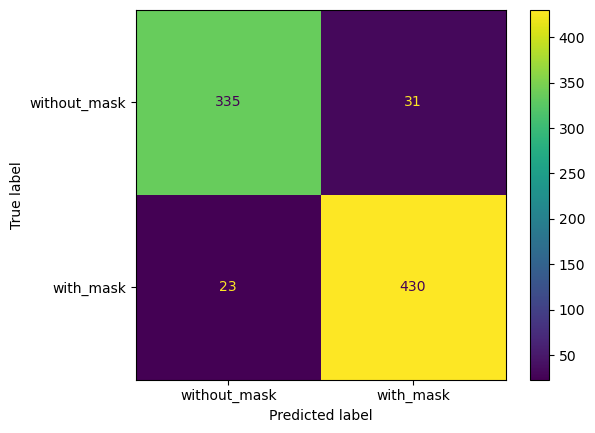

In [67]:
# Predict the labels for the test set
y_pred_cnn_1 = cnn_model_1.predict(X_test)
y_pred_cnn_1_classes = np.argmax(y_pred_cnn_1, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Print confusion matrix
print("Confusion Matrix:")
ConfusionMatrixDisplay.from_predictions(y_test_classes, y_pred_cnn_1_classes, display_labels=['without_mask', 'with_mask'])

In [68]:
# -------------------------- CNN Model 2 --------------------------
def cnn_model_2():
    """CNN Model 2: Uses SGD optimizer, batch normalization."""
    model = Sequential([
        Conv2D(32, (5, 5), activation='relu', input_shape=(128, 128, 1)),
        BatchNormalization(),  # Normalize activations
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, (5, 5), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.3),  # Lower dropout than model 1
        Dense(2, activation='sigmoid')  # 2 output classes
    ])

    # Compile model using SGD optimizer
    model.compile(loss='binary_crossentropy',
                  optimizer=SGD(learning_rate=0.001, momentum=0.9),
                  metrics=['accuracy'])
    
    return model


# Train CNN Model 2
cnn_model_2 = cnn_model_2()
print("\nTraining CNN Model 2 (SGD, batch norm, lower dropout)...")
history_2 = cnn_model_2.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))
test_loss_2, test_acc_2 = cnn_model_2.evaluate(X_test, y_test)
print(f" CNN Model 2 Test Accuracy: {test_acc_2:.4f}")



Training CNN Model 2 (SGD, batch norm, lower dropout)...
Epoch 1/5
103/103 [==============================] - 92s 865ms/step - loss: 0.4460 - accuracy: 0.8153 - val_loss: 0.9700 - val_accuracy: 0.4518
Epoch 2/5
103/103 [==============================] - 91s 881ms/step - loss: 0.2232 - accuracy: 0.9170 - val_loss: 1.6685 - val_accuracy: 0.4469
Epoch 3/5
103/103 [==============================] - 88s 852ms/step - loss: 0.1512 - accuracy: 0.9444 - val_loss: 2.0875 - val_accuracy: 0.4664
Epoch 4/5
103/103 [==============================] - 87s 841ms/step - loss: 0.1123 - accuracy: 0.9625 - val_loss: 1.0747 - val_accuracy: 0.6117
Epoch 5/5
26/26 [==============================] - 6s 241ms/step - loss: 0.4769 - accuracy: 0.7961
 CNN Model 2 Test Accuracy: 0.7961


26/26 [==============================] - 9s 358ms/step
Confusion Matrix:


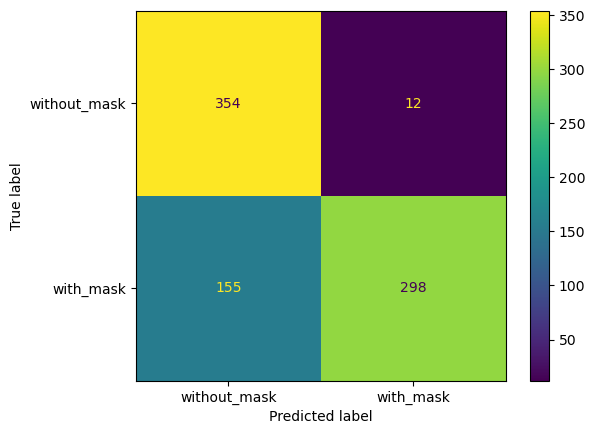

In [69]:
# Predict the labels for the test set using CNN Model 2
y_pred_cnn_2 = cnn_model_2.predict(X_test)
y_pred_cnn_2_classes = np.argmax(y_pred_cnn_2, axis=1)

# Print confusion matrix
print("Confusion Matrix:")
ConfusionMatrixDisplay.from_predictions(y_test_classes, y_pred_cnn_2_classes, display_labels=['without_mask', 'with_mask'])

### Accuracy Comparison

In [70]:
# Compare model performance
data = [
    ["Model 1 SVC", f"{svm_accuracy:.4f}"],
    ["Model 2 MLP neural network", f"{nn_accuracy:.4f}"],
    ["Model 1 (Adam)", f"{test_acc_1:.4f}"],
    ["Model 2 (SGD, batch norm)", f"{test_acc_2:.4f}"]
]

# Print comparison in tabular format
print("\nComparison of Models:")
print(tabulate(data, headers=["Model", "Accuracy"], tablefmt="grid"))


Comparison of Models:
+----------------------------+------------+
| Model                      |   Accuracy |
+============================+============+
| Model 1 SVC                |     0.9304 |
+----------------------------+------------+
| Model 2 MLP neural network |     0.9035 |
+----------------------------+------------+
| Model 1 (Adam)             |     0.9341 |
+----------------------------+------------+
| Model 2 (SGD, batch norm)  |     0.7961 |
+----------------------------+------------+
